In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import pywt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
fpath = "../../data/DNN_data/v2/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v2_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


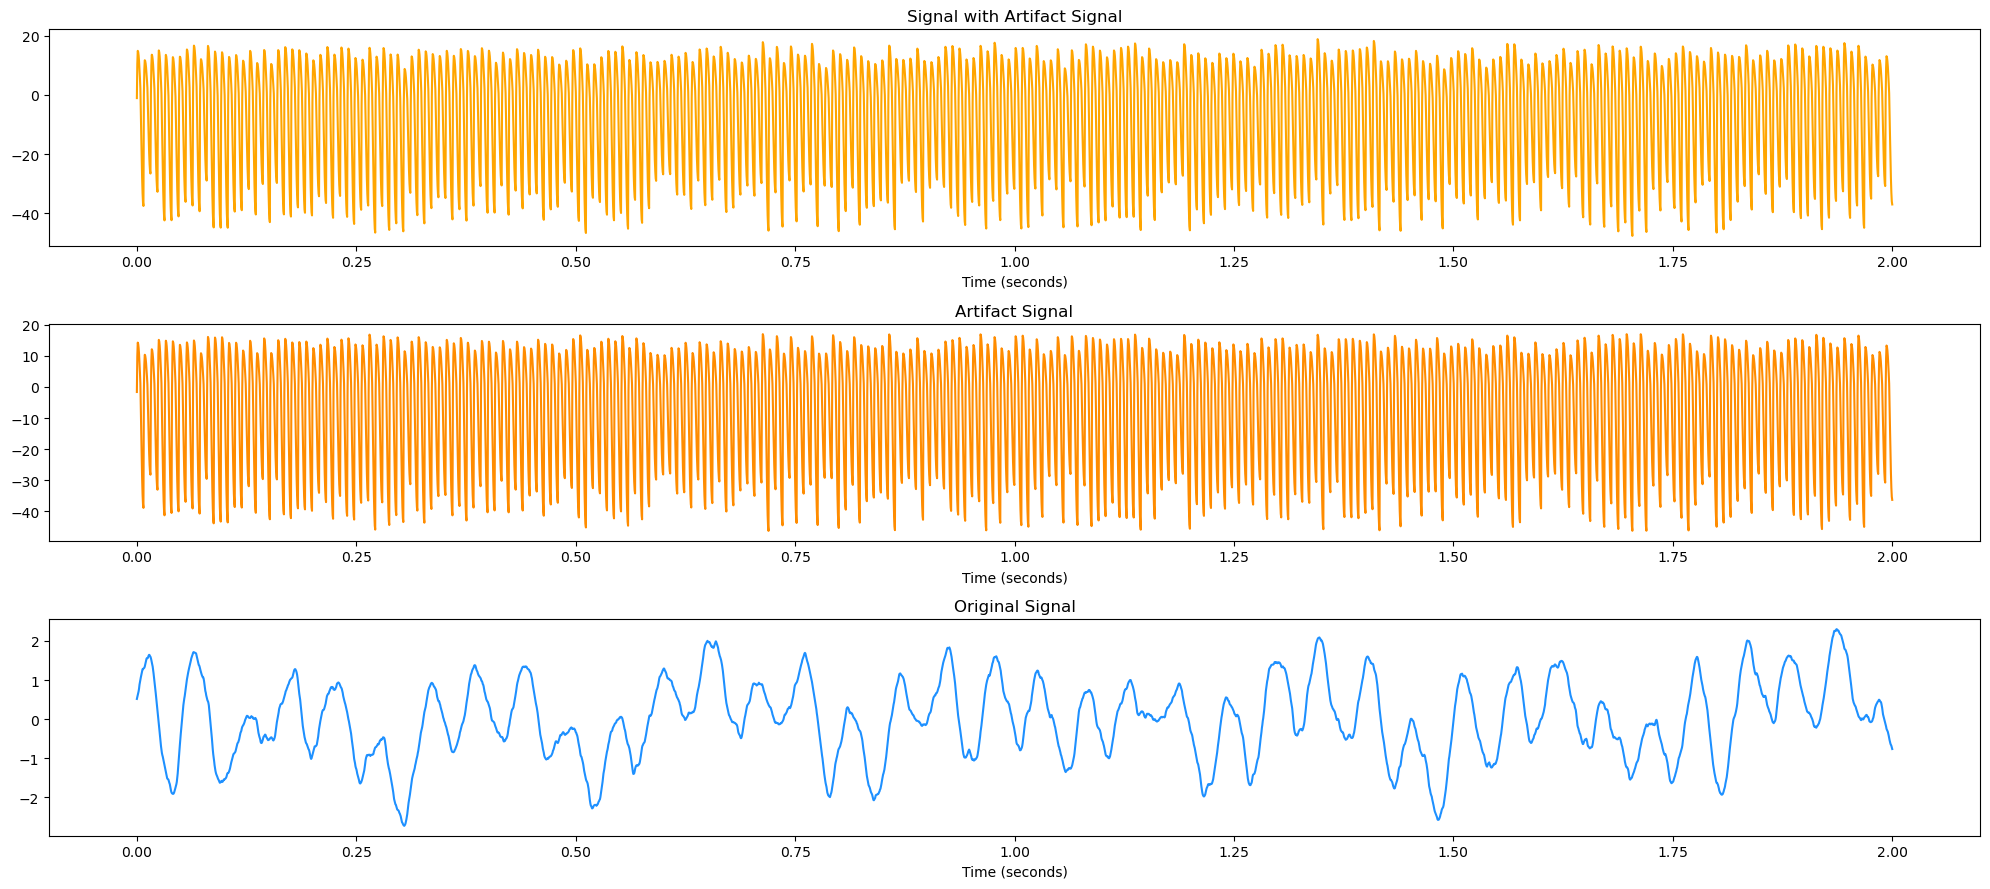

In [3]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,9))
plt.subplot(3, 1, 1)
plt.plot(t, sig_with_artifact[0], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t, artifact[0], color='darkorange')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t, sig[0], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

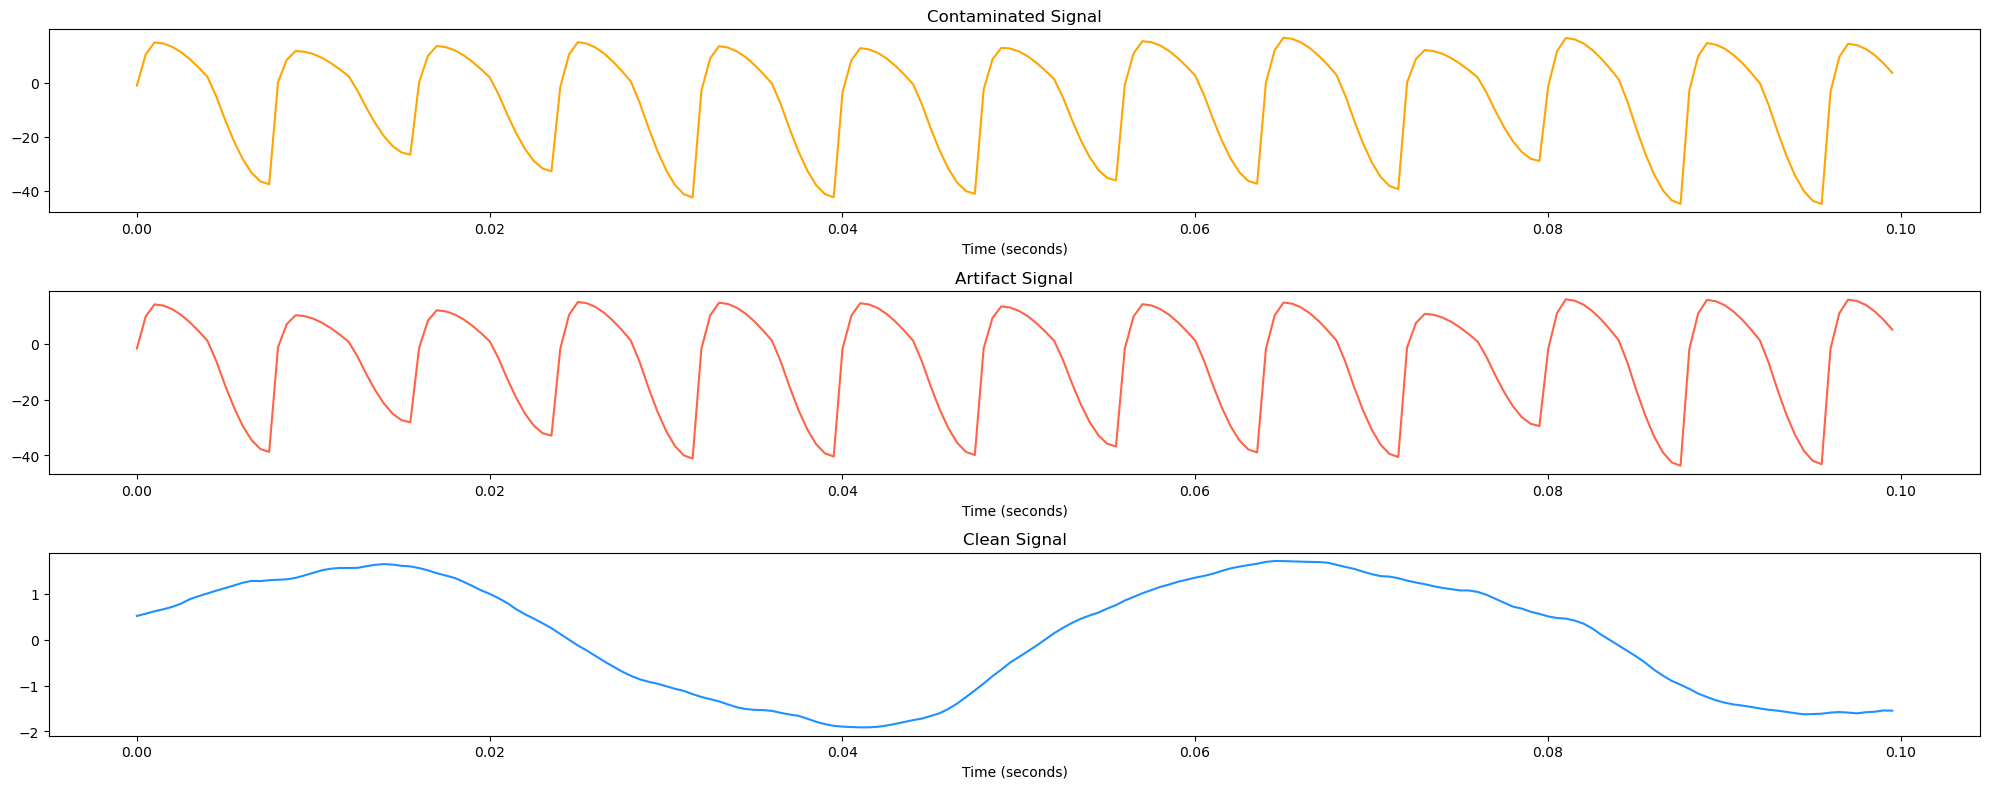

In [4]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Contaminated Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Clean Signal')

plt.tight_layout()

X: (1000, 4000)
y: (1000, 4000)


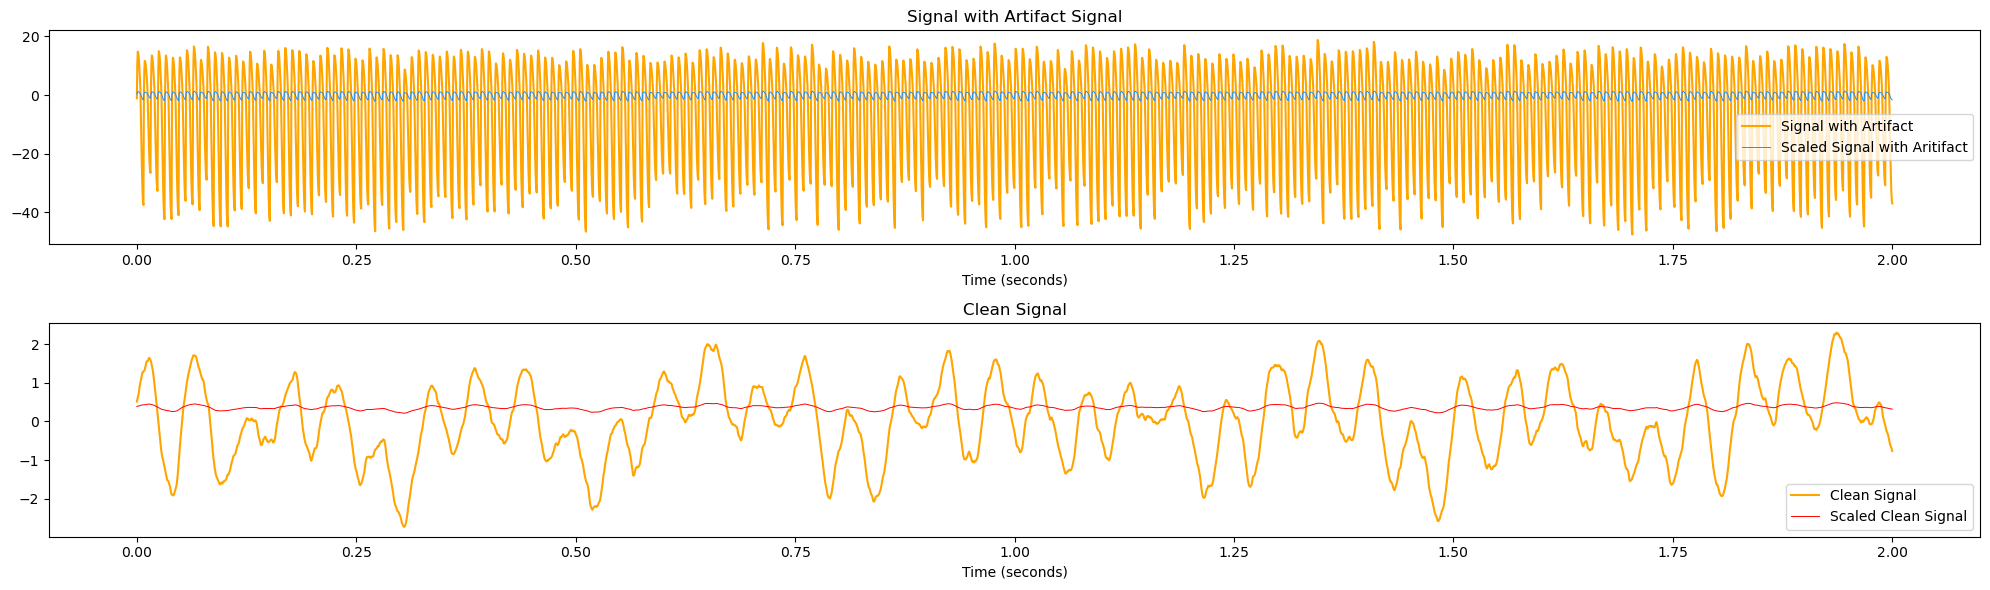

In [5]:
scaler = StandardScaler()

X = scaler.fit_transform(sig_with_artifact.T)
y = (sig.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.T # sig_with_artifact
y = y.T # sig

print("X:", X.shape)
print("y:", y.shape) 

plt.figure(figsize=(20,6))
plt.subplot(2, 1, 1)
plt.plot(t, sig_with_artifact[0], label='Signal with Artifact', color='orange')
plt.plot(t, X[0,:], label='Scaled Signal with Aritifact', color='dodgerblue', alpha=1, linewidth=0.7) #input data
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, sig[0], label='Clean Signal', color='orange')
plt.plot(t, y[0,:], label='Scaled Clean Signal', color='red', alpha=1, linewidth=0.7) # output data
plt.xlabel("Time (seconds)")
plt.title('Clean Signal')
plt.legend()

plt.tight_layout()

In [6]:
# 웨이블릿 변환 및 패딩 처리 함수
def wavelet_transform_and_pad(data, wavelet='db1'):
    coeffs = pywt.wavedec(data, wavelet)
    max_len = max(len(c) for c in coeffs)
    padded_coeffs = [np.pad(c, (0, max_len - len(c)), 'constant') for c in coeffs]
    return np.stack(padded_coeffs, axis=0)

wavelet = 'db1'

X_wt = np.array([wavelet_transform_and_pad(sample_X, wavelet) for sample_X in X])
y_wt = np.array([wavelet_transform_and_pad(sample_y, wavelet) for sample_y in y])

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (1000, 12, 2000)
y_wt: (1000, 12, 2000)


In [7]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X_wt, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x 1 x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 12, 2000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 12, 2000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 1, 12, 2000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 1, 12, 2000)
y_test shape: (200, 4000)
-----------------------------


In [8]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        conv_output_size = out_channels * (height // 2) * (width // 2)  # Assuming pooling reduces each dimension by 2
        self.fc1 = nn.Linear(conv_output_size, 64)
        self.fc2 = nn.Linear(64, 4000)  # 원래 신호의 길이와 동일한 출력
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
num_samples = 1000
height = 12
width = 2000
num_epochs = 100

model = CNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# 모델 평가
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/100, Loss: 2.8227


KeyboardInterrupt: 

In [ ]:
print(outputs.shape, targets.shape)
plt.figure(figsize=(20,3))
plt.plot(t, outputs[0], label='output')
plt.plot(t, targets[0], label='target')
plt.legend()

In [ ]:
# 웨이블릿 변환 수행
wavelet = 'db1'  # Daubechies wavelet
coeffs = pywt.wavedec(X[0], wavelet)

c = 1
for i in coeffs:
    print(f"[{c}]: {len(i)}")
    c += 1

# 변환된 웨이블릿 계수 확인
cA = coeffs[0]  # Approximation coefficients
cD = coeffs[1:]  # Detail coefficients

# 웨이블릿 계수 시각화
fig, ax = plt.subplots(len(coeffs), 1, figsize=(6, 18))

for i in range(len(coeffs)):
    ax[i].plot(coeffs[i])
    ax[i].set_title(f'Coefficients at level {i}')

plt.tight_layout()
plt.show()

# 역변환을 통해 원래 데이터 복원
reconstructed_data = pywt.waverec(coeffs, wavelet)

# 원래 데이터와 복원된 데이터 비교
plt.figure(figsize=(10, 5))
plt.plot(t, X[0], label='Original Data')
plt.plot(t, reconstructed_data, label='Reconstructed Data', linestyle='dashed')
plt.legend()
plt.title('Original vs Reconstructed Data')
plt.show()

print(max(abs(X[0] - reconstructed_data)))


In [ ]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, 4000) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, 4000)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x 1 x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(16, 1, 3, padding=1)
        )
        
        self.drop = nn.Dropout1d(0.25)

    def forward(self, x): # x : B x 1 x T
        x = self.layer1(x)
        x = x.squeeze(1) # x : B x T
        return x

model = CNN().to(device)
print(model)

In [ ]:
# 모델 훈련
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0] # x : B x 1 x T
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

In [ ]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')    

In [ ]:
# time domain plotting

Contaminated_signal = Contaminated[0]
SACed_signal = SACed[0]
Clean_signal = Clean[0]

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('CNN result')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")

In [ ]:
# frequency domain plotting

n = len(SACed_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(SACed_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(Clean_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

fft_nonSACed = np.fft.fft(Contaminated_signal)
fft_nonSACed = np.abs(fft_nonSACed[:n//2])
fft_nonSACed[1:] = 2 * fft_nonSACed[1:]
power_nonSACed = fft_nonSACed**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_nonSACed)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_actual)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_predicted)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.axvline(x=130, color='black', linestyle='--',label='130 Hz', linewidth=0.7)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")